In [1]:
import pandas as pd
import numpy as np

import env
import wrangle
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from scipy import stats
from scipy.stats import pearsonr, spearmanr

import warnings
warnings.filterwarnings("ignore")

# Zillow - Predicting Tax Assessed Value

Lori Ainslie, 12/13/21

***

# Executive Summary

## Project Goals

* To build a model that accurately predicts the property tax assessed values of single family properties that had a transaction during 2017

## Project Description

* Accurately predicting property tax assessed values is important because it provides valuable information to our users and helps predict home values with greater accuracy. The model selected will be evaluated by how well it performs over the baseline and previous models.

# Acquisition & Preparation

In [2]:
# use a function to pull in, clean, split, and scale zillow data. Returns 6 dataframes; 3 unscaled for exploring and 3 scaled for modeling
train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle.wrangle_zillow()
train.shape, validate.shape, test.shape, train_scaled.shape, validate_scaled.shape, test_scaled.shape

((8288, 9), (3552, 9), (2960, 9), (8288, 9), (3552, 9), (2960, 9))

**Steps taken to prepare the data:**

* Became familiar with data (column names, data types, # of observations & features, null values, statistical information, and value counts


* Removed columns missing over 35% of their values and columns with information duplicated elsewhere or less relevant to tax value


* Removed observations to focus on a subset relevant to the largest portion of our users and create better models
  * Properties with less than 2 or more than 5 bedrooms
  * Properties within $200,000 of the Zillow median home price for California in 2017


* Removed nulls and outliers for all other columns


* Renamed columns for readability and changed data types where it made sense


* Created an age column based on year built


* Created dummy variables for columns with object data type


* Used histograms to check out distribution of numerical columns


* Created functions to clean, split, and scale the data

In [3]:
train.head(3)

,bathrooms,bedrooms,area,lot_area,taxvalue,age,los_angeles,orange,ventura
50816,3.0,3,2612,6907.0,562338,14,1,0,0
31475,2.0,3,1374,6004.0,449420,70,1,0,0
36038,2.0,4,1310,4714.0,470000,45,0,0,1


***

# Exploration

## Does location affect property tax value?

In [4]:
# use function to append county column using encoded column values
train = wrangle.append_county_col(train)

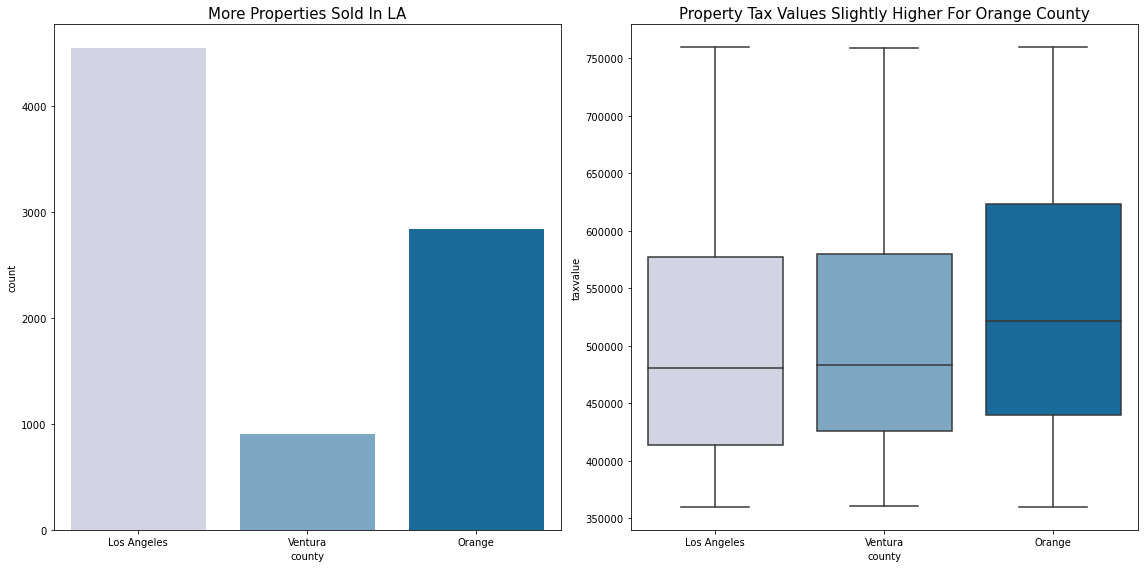

In [5]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
sns.countplot(x='county', palette='PuBu', data=train)
plt.title('More Properties Sold In LA', fontsize=15)

plt.subplot(1,2,2)
sns.boxplot(x='county', y='taxvalue', data=train , palette='PuBu')
plt.title('Property Tax Values Slightly Higher For Orange County', fontsize=15)

plt.tight_layout()

## Property tax values are somewhat higher for Orange County but otherwise similar

***

## Does number of bedrooms affect property tax value?

Text(0.5, 1.0, 'Unclear Relationship Between # Of Bedrooms & Property Tax Value')

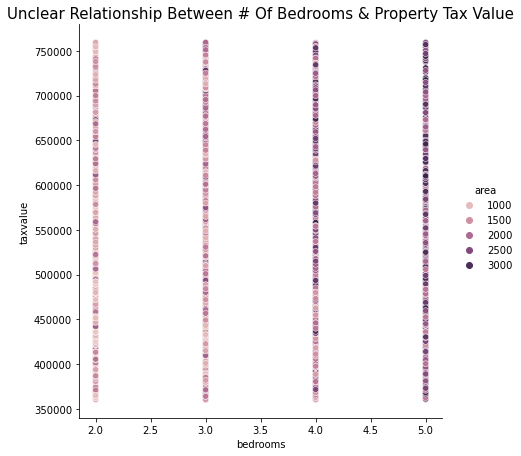

In [6]:
ax = sns.relplot(x='bedrooms', y='taxvalue', data=train, kind='scatter', hue='area', height=6)
# ax.set(yscale='log')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Unclear Relationship Between # Of Bedrooms & Property Tax Value', size=15)

**Hypothesis testing using Pearson's r to see if this is statistically significant since chart is not very clear:**

**Null Hypothesis: There is no linear relationship between number of bedrooms and the tax value of a property**

**Alternate Hypothesis: There is a linear relationship between number of bedrooms and the tax value of a property**

In [7]:
alpha = 0.05

r, p_value = pearsonr(train.bedrooms, train.taxvalue)

if p_value > alpha:
    print('We fail to reject the null hypothesis')
else:
    print('We reject the null hypothesis')
print(f'p-value: {round(p_value,3)}')

We reject the null hypothesis
p-value: 0.0


## Even though not visible in the chart, there does appear to be a linear relationship between number of bedrooms and property tax value

***

## Does number of bathrooms affect property tax value?

Text(0.5, 1.0, 'Unclear Relationship Between # Of Bathrooms & Property Tax Value')

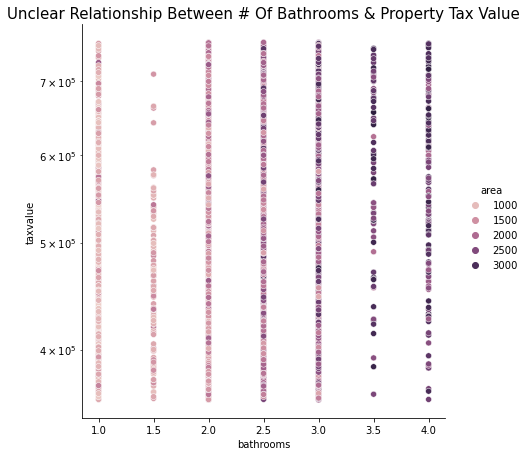

In [8]:
ax2 = sns.relplot(x='bathrooms', y='taxvalue', data=train, kind='scatter', hue='area', height=6)
ax2.set(yscale='log')
# plt.ticklabel_format(style='plain', axis='y')
plt.title('Unclear Relationship Between # Of Bathrooms & Property Tax Value', size=15)

**Hypothesis testing using Pearson's r to see if this is statistically significant since chart is not very clear:**

**Null Hypothesis: There is no linear relationship between number of bathrooms and the tax value of a property**

**Alternate Hypothesis: There is a linear relationship between number of bathrooms and the tax value of a property**

In [9]:
alpha = 0.05

r, p_value = pearsonr(train.bathrooms, train.taxvalue)

if p_value > alpha:
    print('We fail to reject the null hypothesis')
else:
    print('We reject the null hypothesis')
print(f'p-value: {round(p_value,3)}')

We reject the null hypothesis
p-value: 0.0


## Statistical testing confirms, there does appear to be a linear relationship between number of bathrooms and property tax value

***

## What features do have the highest correlation with property tax value?

Text(0.5, 1.0, 'Area Has Highest Correlation With Property Tax Value (0.3)')

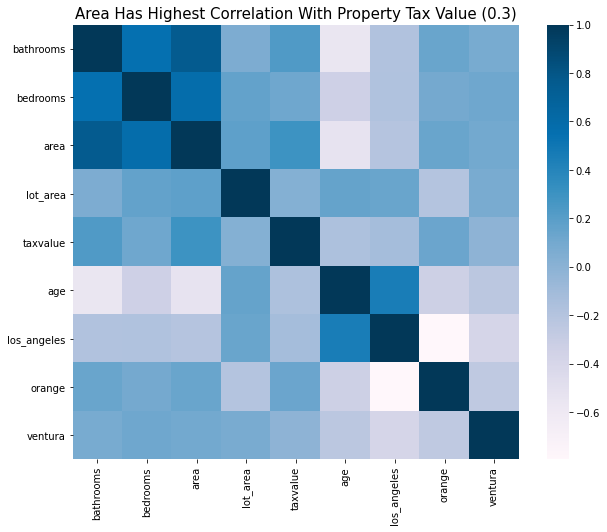

In [10]:
plt.figure(figsize=(10, 8))
cmap = sns.cubehelix_palette()
sns.heatmap(train.corr(), cmap='PuBu')
plt.title('Area Has Highest Correlation With Property Tax Value (0.3)', size=15)

## Area has the highest correlation with property tax value at 0.3 followed by # of bathrooms at 0.23. 

## Exploration Summary


**- There is a relationship between number of bedrooms/bathrooms and property tax value although not as much as one would expect**

**- Area has a higher correlation with property tax value**

**- Going forward these features will be used for modeling and predicting property tax value. Lot area, age, and county will be dropped**

***

# Modeling

In [24]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.create_x_y(train, validate, test, train_scaled, validate_scaled, test_scaled)

In [25]:
# establish a baseline for predicted tax value using median which is common for housing values
y_train['baseline'] = train.taxvalue.median()
y_validate['baseline'] = train.taxvalue.median()

# calculate baseline rmse for train and validate using median which is common for housing values
baseline_rmse_train = mean_squared_error(y_train.taxvalue, y_train.baseline)**(1/2)
baseline_rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.baseline)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(baseline_rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(baseline_rmse_validate, 2))

RMSE using Median
Train/In-Sample:  109584.76 
Validate/Out-of-Sample:  109060.92


In [26]:
# create the Linear Regression model object
lm = LinearRegression(normalize=True)

# fit the model to training data and specify column in y_train  
lm.fit(X_train, y_train.taxvalue)

# predict train & validate
y_train['pred_lm'] = lm.predict(X_train)
y_validate['pred_lm'] = lm.predict(X_validate)

# evaluate rmse for train & validate
lm_rmse_train = mean_squared_error(y_train.taxvalue, y_train.pred_lm)**(1/2)
lm_rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", lm_rmse_train, 
      "\nValidation/Out-of-Sample: ", lm_rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  102387.81235420196 
Validation/Out-of-Sample:  100821.95686884897


In [27]:
# create the LassoLars model object
lars = LassoLars(alpha=1.5)

# fit the model to training data and specify column in y_train 
lars.fit(X_train, y_train.taxvalue)

# predict train & validate
y_train['pred_lars'] = lars.predict(X_train)
y_validate['pred_lars'] = lars.predict(X_validate)

# evaluate rmse for train & validate
lars_rmse_train = mean_squared_error(y_train.taxvalue, y_train.pred_lars)**(1/2)
lars_rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", lars_rmse_train, 
      "\nValidation/Out-of-Sample: ", lars_rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  102388.30494578095 
Validation/Out-of-Sample:  100826.83434543133


In [16]:
# create new features for train, validate, and test based on value indicated for use with Polynomial Regression model
pf = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate & X_test
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [28]:
# create the Polynomial Regression model object
lm2 = LinearRegression(normalize=True)

# fit the model to training data and specify column in y_train
lm2.fit(X_train_degree2, y_train.taxvalue)

# predict train & validate
y_train['pred_lm2'] = lm2.predict(X_train_degree2)
y_validate['pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate rmse for train & validate
pr_rmse_train = mean_squared_error(y_train.taxvalue, y_train.pred_lm2)**(1/2)
pr_rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", pr_rmse_train, 
      "\nValidation/Out-of-Sample: ", pr_rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  102037.82621528127 
Validation/Out-of-Sample:  100623.40885693024


In [29]:
# use best model on test
y_test['pred_lm2'] = lm2.predict(X_test_degree2)
pr_rmse_test = mean_squared_error(y_test.taxvalue, y_test.pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTest/Out-of-Sample: ", pr_rmse_test)

RMSE for Polynomial Model, degrees=2
Test/Out-of-Sample:  100883.58236723735


# Conclusion


## Summary

Goals of this project were:

* To build a model that accurately predicts the property tax assessed values of single family properties that had a transaction during 2017

We identified some of the drivers of property tax value as:

* Area

* Bathrooms

* Bedrooms

We built a model that is expected to perform with an RMSE of about $101,000 on unseen data.


## Recommendations

- Improve methods of data collection so that features that were not used because of null values may be implemented


## Next Steps

- With more time and resources, I would like to conduct more feature engineering and explore the relationships between property tax value and features which initially may not seem important